In [542]:
# import autograd.numpy as np
import numpy as np
from pymanopt.manifolds import Stiefel, Sphere
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent
from geomstats.geometry.hypersphere import Hypersphere
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import geomstats.backend as gs

gs.random.seed(2020)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 9)

# Setting up the Hypersphere

In [543]:
# Sampling Hypersphere
n_samples=1000
dim = 2
sphere = Hypersphere(dim=dim)
points_in_manifold = sphere.random_uniform(n_samples)

In [544]:
# Creating Initial Point and Tangent Vector
x_0 = points_in_manifold[0,:]
vector = gs.array([1, 0, 1])
tangent_vector = sphere.to_tangent(vector, base_point=x_0)

print(f'Starting Point on manifold: {x_0}')
print(f'Tangent Vector: {tangent_vector}')

Starting Point on manifold: [-0.84203574  0.03596567 -0.5382214 ]
Tangent Vector: [-0.16222585  0.04964187  0.25711606]


In [545]:
# Wireframe for Sphere Surface
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)

#https://stackoverflow.com/questions/11140163/plotting-a-3d-cube-a-sphere-and-a-vector-in-matplotlib

Text(0.5, 0.92, 'Hypersphere of Dimension 3')

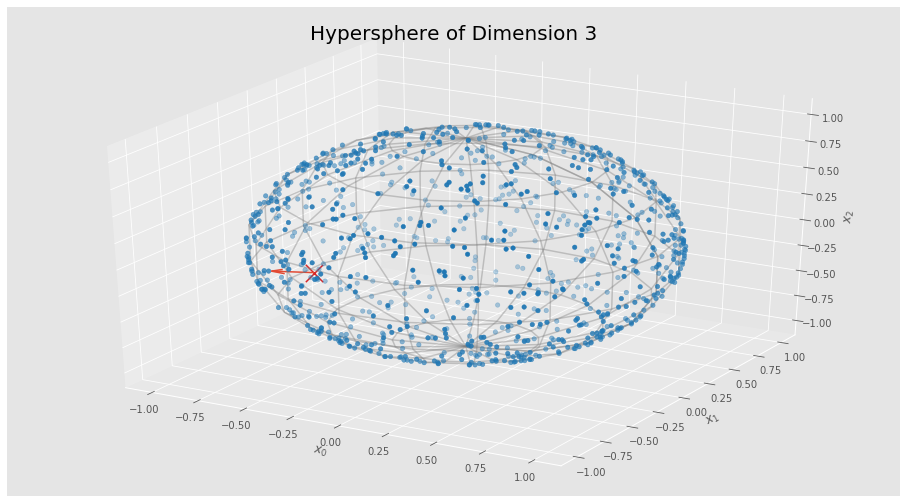

In [546]:
# Plotting Points in 3D
ax = plt.axes(projection='3d')

# Points with first one Highlighted
ax.scatter(points_in_manifold[1:,0],points_in_manifold[1:,1],points_in_manifold[1:,2],color="tab:blue",s=20)
ax.scatter(points_in_manifold[0,0],points_in_manifold[0,1],points_in_manifold[0,2],color="tab:red",s=300, marker="x")

# Tangent Vector
ax.quiver(points_in_manifold[0,0],points_in_manifold[0,1],points_in_manifold[0,2],
          points_in_manifold[0,0] + tangent_vector[0],points_in_manifold[0,1] + tangent_vector[1],points_in_manifold[0,2] + 
          tangent_vector[2], length=0.25)
# Sphere
ax.plot_wireframe(x, y, z, color="grey", alpha=0.4)
ax.set_xlabel(r'$x_0$')
ax.set_ylabel(r'$x_1$')
ax.set_zlabel(r'$x_2$')
ax.set_title(f'Hypersphere of Dimension {dim + 1}', fontsize=20)

In [547]:
def sphere_exp_map(v, x):
    """
    Input: v (tangent vector), x (starting point on manifold)
    Output: ... (point restrained to manifold)
    """
    r = 1 # assuming unit sphere
    ans = x * np.cos(np.linalg.norm(v)/r) + (r*v/np.linalg.norm(v))*np.sin(np.linalg.norm(v)/r)
    return ans

def sphere_R_map(v, x):
    """
    Input: v (tangent vector), x (starting point on manifold)
    Output: ... (point restrained to manifold)
    """
    r = 1 # assuming unit sphere
    num = x + v
    denom = np.linalg.norm(x + v)
    return r * (num / denom)

# https://wiseodd.github.io/techblog/2019/02/22/optimization-riemannian-manifolds/

In [548]:
# Testing Exponential Mapping
x_manifold = sphere_exp_map(tangent_vector, x_0)
x_manifold_geomstats = sphere.metric.exp(tangent_vector, base_point=x_0)

# https://geomstats.github.io/notebooks/02_from_vector_spaces_to_manifolds.html

In [549]:
print(f'Point from our Function: {x_manifold}\nPoint from GeomStats: {x_manifold_geomstats}')

Point from our Function: [-0.96207257  0.08313322 -0.25981771]
Point from GeomStats: [-0.96207257  0.08313322 -0.25981771]


In [550]:
# Testing Retraction Mapping
x_manifold_R = sphere_R_map(tangent_vector, x_0)
x_manifold_geomstats_R = sphere.metric.exp(tangent_vector, base_point=x_0)

In [551]:
x_manifold_R
# Not sure if geomstats has an option for retraction built in for sphere...

array([-0.95975762,  0.08181382, -0.26864813])

# First Order Optimization Methods

## Riemanian Gradient Descent

In [552]:
def RGD(x, lam, GradR, GradRet, f=None, tol=1e-7, max_iter=1e4):
    """
    Input: x (starting point on manifold), lam (step size) IMPLEMENT LINE SEARCH VARIANTS TOO, f (cost function), algo (1 = Retraction, 0 = Exponential Mapping)
    Output: Point on manifold that minimizes cost function
    """
    err = []
    x_prev = x
    if f != None:
        for i in range(int(max_iter)):
        
            r_grad = GradR(x) # riemannian gradient
            lam = linesearch(x, f, GradRet, GradR)
            x = GradRet(-lam*r_grad, x) # riemannian descent
            
            error = np.linalg.norm(x - x_prev)/np.linalg.norm(x)
            err.append(error)
            if error < tol: # stopping criteria
                return x, err
            x_prev = x
            
        print(f'Reached max iterations.')
        return x, err
    else:

        for i in range(int(max_iter)):
            
            r_grad = GradR(x) # riemannian gradient
            x = GradRet(-lam*r_grad, x) # riemannian descent
            
            error = np.linalg.norm(x - x_prev)/np.linalg.norm(x)
            err.append(error)
            if error < tol: # stopping criteria
                return x, err
            x_prev = x
        
        print(f'Reached max iterations.')
        return x, err

In [553]:
def SphereRGrad(x, u):
    I = np.identity(len(x))
    return (I - x * x.T) @ u(x)
def linesearch(x, f, GradRet, GradR):
    r = 1e-4
    tau = 0.8
    t = 1
    while (f(x) - f(GradRet(-t * GradR(x), x))) < r * t * np.linalg.norm(GradR(x))**2:
        t = tau * t
    return t


# Second Order Optimization Methods

In [554]:
# Define hypershphere dimension and A matrix for cost function
dim = 10
A = np.random.rand(dim,dim)
A = 1/2*(A + A.T)

# Define cost function, euclidean gradient of cost, and riemannian gradient
f = lambda x: 0.5*x.T @ A @ x
df = lambda x: A @ x
gradR = lambda x: SphereRGrad(x, df)

In [555]:
# Costant Learning Rate and inital value
lam = 0.05
x_0 = np.random.rand(dim,1)

# Running RGD on variants
x_optimal = RGD(x_0, lam, gradR, sphere_R_map, f=None)
x_optimal_ls = RGD(x_0, lam, gradR, sphere_R_map, f=f)
x_optimal_eucl = RGD(x_0, lam, df, sphere_R_map, f=None)
x_optimal_eucl_ls = RGD(x_0, lam, df, sphere_R_map, f=f)

# Results
print(f'Optimal Value is {x_optimal[0]}\n achieved in {len(x_optimal[1])} iterations.')
print(f'Optimal Value is {x_optimal_ls[0]}\n achieved in {len(x_optimal_ls[1])} iterations.')
print(f'Optimal Value is {x_optimal_eucl[0]}\n achieved in {len(x_optimal_eucl[1])} iterations.')
print(f'Optimal Value is {x_optimal_eucl_ls[0]}\n achieved in {len(x_optimal_eucl_ls[1])} iterations.')

Optimal Value is [[-0.33780959]
 [ 0.20897256]
 [-0.64280208]
 [-0.07572743]
 [ 0.43689091]
 [ 0.06177674]
 [ 0.43630913]
 [-0.04714052]
 [-0.02063091]
 [ 0.18863308]]
 achieved in 526 iterations.
Optimal Value is [[-0.33781011]
 [ 0.20897084]
 [-0.64280107]
 [-0.07572856]
 [ 0.43689279]
 [ 0.0617749 ]
 [ 0.43630959]
 [-0.04713983]
 [-0.02062983]
 [ 0.18863251]]
 achieved in 116 iterations.
Optimal Value is [[-0.33780956]
 [ 0.20897267]
 [-0.64280215]
 [-0.07572735]
 [ 0.43689078]
 [ 0.06177686]
 [ 0.4363091 ]
 [-0.04714057]
 [-0.02063098]
 [ 0.18863312]]
 achieved in 556 iterations.
Optimal Value is [[-0.33603057]
 [ 0.21243282]
 [-0.64438078]
 [-0.07243678]
 [ 0.43324087]
 [ 0.0665174 ]
 [ 0.43642575]
 [-0.04875743]
 [-0.02251537]
 [ 0.18975829]]
 achieved in 39 iterations.


## Eigenvalue Checking for Specific Cost Function

In [556]:
# Eigenvalues, eigenvectors = ...
u, v = np.linalg.eigh(A)

In [557]:
print(f'Eigenvalues: {u}')
idx = np.argmin(u)
v[:,idx]
print(f'Most negative eigenvalue\'s eigenvector: {u}')

# Optimal Value of Objective Function (corresponds to most negative eigenvalue)
f(x_optimal[0])*2

Eigenvalues: [-1.39323078 -0.91871804 -0.66735595 -0.51856618 -0.14327788 -0.02281103
  0.31590927  0.55029942  0.88996839  5.60527232]
Most negative eigenvalue's eigenvector: [-1.39323078 -0.91871804 -0.66735595 -0.51856618 -0.14327788 -0.02281103
  0.31590927  0.55029942  0.88996839  5.60527232]


array([[-1.39323078]])

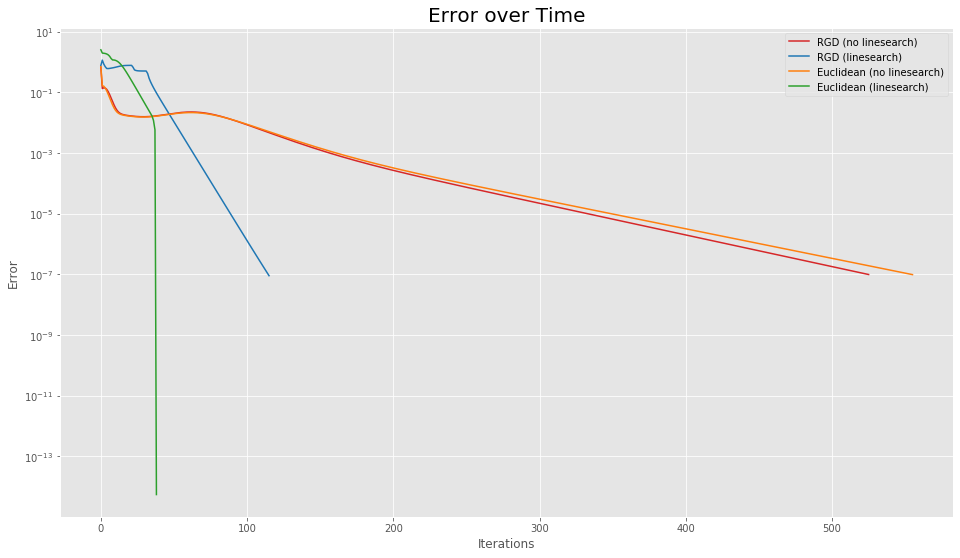

In [558]:
# Plotting local error over time
plt.plot(x_optimal[1], color='tab:red', label='RGD (no linesearch)')
plt.plot(x_optimal_ls[1], color='tab:blue', label='RGD (linesearch)')
plt.plot(x_optimal_eucl[1], color='tab:orange', label='Euclidean (no linesearch)')
plt.plot(x_optimal_eucl_ls[1], color='tab:green', label='Euclidean (linesearch)')
plt.title('Error over Time', fontsize=20)
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.yscale('log')
plt.legend()

In [559]:
import autograd.numpy as np

from pymanopt.manifolds import Stiefel, Sphere
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent

# # (1) Instantiate a manifold
manifold = Sphere(dim)

In [560]:
# (2) Define the cost function (here using autograd.numpy)
# def cost(X): return np.sum(X)

problem = Problem(manifold=manifold, cost=f)

# (3) Instantiate a Pymanopt solver
solver = SteepestDescent()

# let Pymanopt do the rest
Xopt = solver.solve(problem)
print(Xopt)

Compiling cost function...
Computing gradient of cost function...
 iter		   cost val	    grad. norm
    1	-7.7122732098155955e-02	1.35841014e+00
    2	-2.9195298091811722e-01	1.37810971e+00
    3	-3.1072654739339800e-01	1.89090078e+00
    4	-3.8148960157850276e-01	1.67354765e+00
    5	-5.7946701757616592e-01	7.08285517e-01
    6	-5.8543296326643612e-01	9.79529706e-01
    7	-6.0741651874547475e-01	8.25888631e-01
    8	-6.5931686977280546e-01	2.27853463e-01
    9	-6.6315429839848250e-01	5.68584914e-01
   10	-6.7607385306031254e-01	3.89901549e-01
   11	-6.8768656459834532e-01	1.16941156e-01
   12	-6.9001379661805762e-01	1.51734434e-01
   13	-6.9204960568212959e-01	8.46017585e-02
   14	-6.9235005359593260e-01	1.70963498e-01
   15	-6.9339130803224058e-01	1.25870511e-01
   16	-6.9420518982457213e-01	1.06125563e-01
   17	-6.9461331887467992e-01	1.06133947e-01
   18	-6.9550151516364866e-01	3.24860389e-02
   19	-6.9615916736252259e-01	3.63333936e-02
   20	-6.9627672773265070e-01	2.84826542e-02


In [561]:
print(f'PyManOpt: {Xopt}')
print(f'Ours: {x_optimal[0]}')

PyManOpt: [-0.33781022  0.20897025 -0.64280061 -0.07572892  0.43689356  0.06177428
  0.43630984 -0.0471395  -0.02062934  0.18863236]
Ours: [[-0.33780959]
 [ 0.20897256]
 [-0.64280208]
 [-0.07572743]
 [ 0.43689091]
 [ 0.06177674]
 [ 0.43630913]
 [-0.04714052]
 [-0.02063091]
 [ 0.18863308]]
